# Midterm:Practical

Student Name:

Student#:


#Evasion Attacks: FGSM & PGD


In this practical test, you are going to implement and test evasion attacks using the Fast Gradient Sign Method (FGSM) and Projected Gradient Descent (PGD). You will evaluate the performance of a model on clean data and adversarial examples crafted through these attacks.






 # Step 1:
Environment setup, Import necessary libraries

In [2]:
try:
    import secml
except ImportError:
    %pip install git+https://github.com/pralab/secml

try:
    import foolbox
except:
    %pip install foolbox

try:
    import robustbench
except ImportError:
    %pip install git+https://github.com/RobustBench/robustbench.git


import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from secml.data.loader import CDataLoaderMNIST
from secml.data import CDataset
from secml.array import CArray
from secml.ml.peval.metrics import CMetricAccuracy
from secml.ml import CClassifierPyTorch


# Step 2:

Load MNIST data set and DNN model as follows:


1.  Load the MNIST dataset and split the dataset into training and testing
2.	Create a Deep Neural Network(DNN) of your choice with **PyTorch and SecML** wrapper class
 **Note:** use a very simple network (e.g., 1 or 2 layers) to keep this step quick. Remembner the task is more about understanding and implementing evasion attacks rather than building the most complex model.
3.  Train the model on the clean MNIST dataset
4.  **Visualize** some sample images from the test set along with their predictions.
5.  Calculate the accuracy in the standard scenario, i.e. not under attack.


In [3]:
#Step 2.1
loader=CDataLoaderMNIST()
dataset=loader.load('training')

n_tr,n_ts = 800,200
tr_set = dataset[:n_tr, :]
ts_set = dataset[n_tr:n_tr+n_ts, :]
print(tr_set.X.shape)
print(ts_set.X.shape)

tr_set.X = tr_set.X / 255.0
ts_set.X = ts_set.X / 255.0




File stored in `/root/secml-data/datasets/mnist/train-images-idx3-ubyte.gz`

File stored in `/root/secml-data/datasets/mnist/train-labels-idx1-ubyte.gz`

File stored in `/root/secml-data/datasets/mnist/t10k-images-idx3-ubyte.gz`

File stored in `/root/secml-data/datasets/mnist/t10k-labels-idx1-ubyte.gz`
(800, 784)
(200, 784)


In [4]:
#Step 2.2
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,10,kernel_size=5)
        self.conv2 = nn.Conv2d(10,20,kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2, 2)
        x = x.view(-1, 320)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
#Step 2.3
model=Net()
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

clf = CClassifierPyTorch(
    model=model,
    loss=loss,
    optimizer=optimizer,
    epochs=10,
    batch_size=64,
    input_shape=(1, 28, 28),
    softmax_outputs=True
)
clf.fit(tr_set.X, tr_set.Y)
preds = clf.predict(ts_set.X)


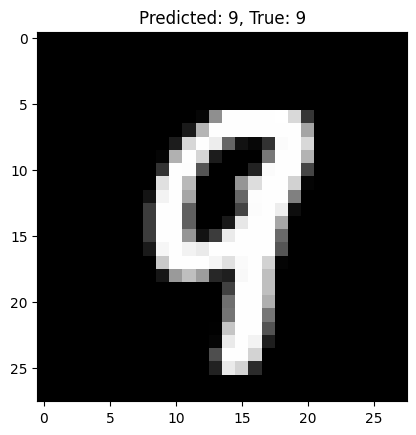

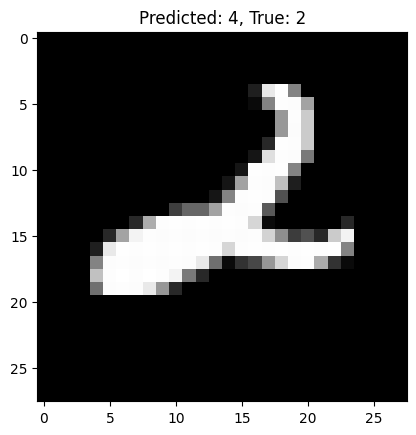

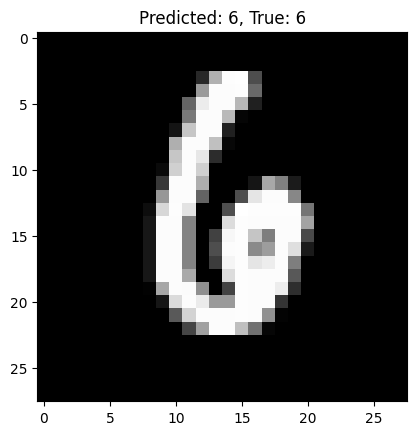

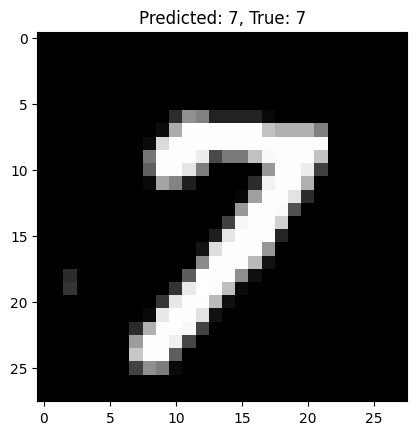

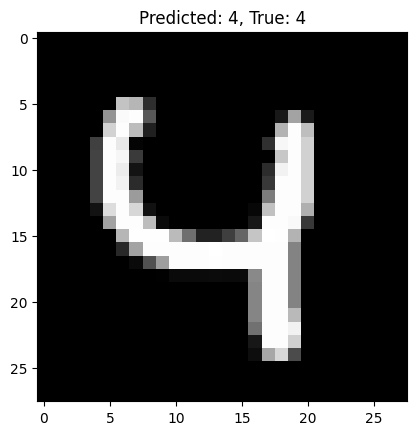

In [6]:
#Step 2.4


for i in range(5):

  image = ts_set.X[i, :].tondarray().reshape(28, 28)
  image_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).float()

  prediction = clf.predict(image_tensor)
  true_label = ts_set.Y[i]

  plt.imshow(image, cmap='gray')
  plt.title(f"Predicted: {prediction.item()}, True: {true_label.item()}")
  plt.show()

In [7]:
# Step 2.5
metric = CMetricAccuracy()
acc_before_attack = metric.performance_score(y_true=ts_set.Y, y_pred=preds)
print(f"Accuracy_before_adding_noice: {acc_before_attack * 100:.2f}%")

Accuracy_before_adding_noice: 88.50%


#Step 3: Crafting Adversarial Examples Using FGSM

1. Implement the Fast Gradient Sign Method (FGSM) attack from SecML. Use the following parameters:
epsilon = 0.1
2. Generate adversarial examples using FGSM and visualize some original vs. adversarial images.
3. Evaluate and compare the model's accuracy on the adversarial examples vs. the clean test set.

In [8]:
#step 3.1
from secml.adv.attacks import CFoolboxFGM
eps=0.1
attack1 = CFoolboxFGM(
    classifier=clf,
    epsilons=eps
)


attack_samples = ts_set[:100, :]

y_pred, _, adv_ds1, _ = attack1.run(attack_samples.X, attack_samples.Y)



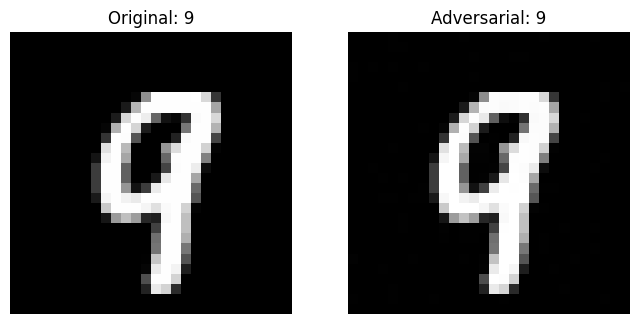

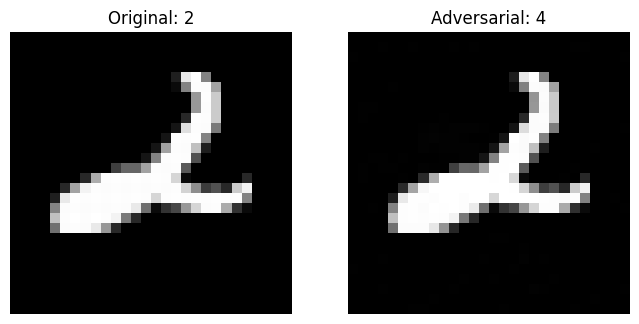

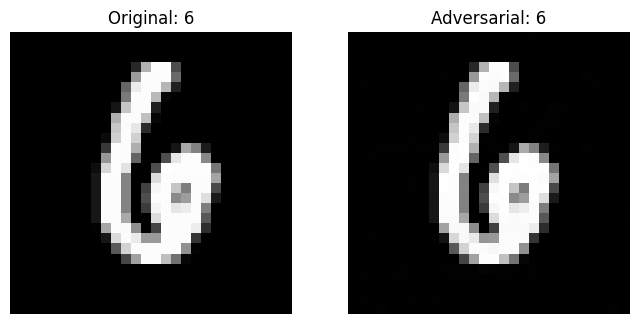

In [9]:
#step 3.2
for i in range(3):
    plt.figure(figsize=(8, 4))


    plt.subplot(1, 2, 1)
    plt.imshow(attack_samples.X[i, :].tondarray().reshape(28, 28), cmap='gray')
    plt.title(f'Original: {attack_samples.Y[i].item()}')
    plt.axis('off')


    plt.subplot(1, 2, 2)
    plt.imshow(adv_ds1.X[i, :].tondarray().reshape(28, 28), cmap='gray')
    plt.title(f'Adversarial: {y_pred[i].item()}')
    plt.axis('off')

    plt.show()

In [10]:
#step 3.3
acc_after_attack = metric.performance_score(y_true=attack_samples.Y, y_pred=y_pred)
print(f"Accuracy after attack: {acc_after_attack * 100:.2f}%")
print(f"change in accuracy: {(acc_before_attack - acc_after_attack) * 100:.2f}%")

Accuracy after attack: 87.00%
change in accuracy: 1.50%


#Step 4: Crafting Adversarial Examples Using PGD

1. Implement the Projected Gradient Descent (PGD-LInf) attack from SecML with the following parameters:
epsilons = 0.2
rel_stepsize = 0.025
steps = 50
2. Generate adversarial examples using PGD and visualize the original and perturbed digits with their predictions.
3. Compute the model’s accuracy on the PGD-crafted adversarial examples and compare it with the accuracy on clean data and FGSM examples.

In [11]:
#step 4.1
from secml.adv.attacks import CFoolboxPGDLinf
eps=0.2
lb,ub=0,1
alpha=0.025
steps=50
attack = CFoolboxPGDLinf(
    classifier=clf,
    y_target=None,
    lb=lb, ub=ub,
    epsilons=eps,
    rel_stepsize= alpha,
    steps=steps,
    random_start=False
)


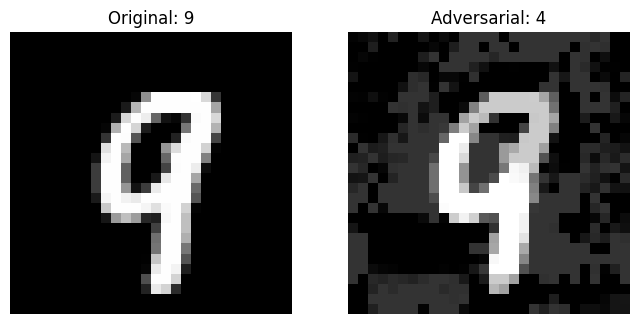

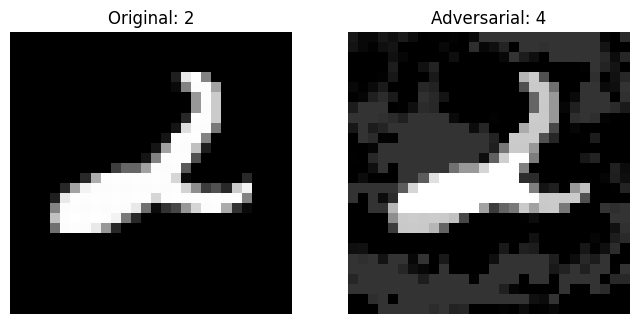

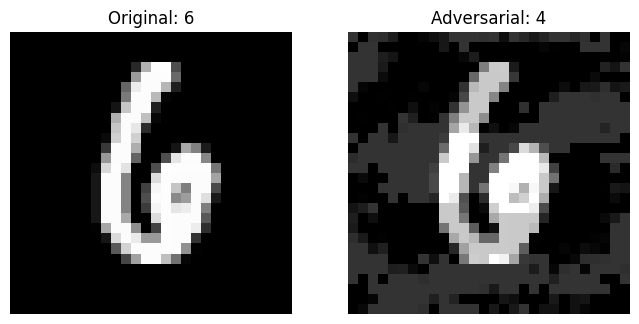

In [13]:
#step 4.3
attack_samples = ts_set[:20, :]

y_pred, _, adv_ds, _ = attack.run(attack_samples.X, attack_samples.Y)
for i in range(3):
    plt.figure(figsize=(8, 4))


    plt.subplot(1, 2, 1)
    plt.imshow(attack_samples.X[i, :].tondarray().reshape(28, 28), cmap='gray')
    plt.title(f'Original: {attack_samples.Y[i].item()}')
    plt.axis('off')


    plt.subplot(1, 2, 2)
    plt.imshow(adv_ds.X[i, :].tondarray().reshape(28, 28), cmap='gray')
    plt.title(f'Adversarial: {y_pred[i].item()}')
    plt.axis('off')

    plt.show()

In [14]:
#step 4.3
acc_after_attack = metric.performance_score(y_true=attack_samples.Y, y_pred=y_pred)
print(f"Accuracy after attack: {acc_after_attack * 100:.2f}%")
print(f"change in accuracy: {(acc_before_attack - acc_after_attack) * 100:.2f}%")

Accuracy after attack: 5.00%
change in accuracy: 83.50%


#Step 5: Discussion

1. Define Evasion attack?
2. What is the different between Targeted and Un-Targeted attack
3. Is previously generated examples was successfull in fooling the classifier?Share your insight on the result.

Answer 5.1

Evasion attack is a method to add some pertubation in the input in such a way that the model will not be able to correctly classify /predict the correct class for the input

Answer 5.2

Targeted attack specifies the output class after the pertubation but in case of the untargeted attack  the output is not defined(y_target=None)

Answer 5.3

with the FGSM attack  slight decrease of 1.5% was observed but with the attack pgdlinfinite models accuracy went from 89 to 5%
these changes were because of the way both attacks works in case of fgsm the pertubation is added in a one step basis that is good for computational power but in terms of affect it has minimal effect but as the PGDl works in multi step requires high computational power but also have better results


# Discussion goes here:

# Submission:
Please submit your notebook to the relevant submission folder
1. Submit your notebook file (.ipynb) for easier evaluation of the code with output.
2. Additionally, you can provide a PDF of the notebook as an optional choice for easier reading and grading.


#Rubric:
**Step 1: Environment Setup (10 Points)**

1. Full points for setting up and importing all necessary libraries correctly.
Partial points if there are minor issues with setup.

**Step 2: Loading MNIST and Model Training (25 Points)**

1. 10 points for correctly loading and splitting the MNIST dataset.
2. 10 points for implementing and training a neural network correctly using PyTorch and SecML.
3. 5 points for providing sample visualizations of test images with accurate predictions.

**Step 3: FGSM Attack (20 Points)**

1. 10 points for correctly implementing FGSM with the specified epsilon value.
2. 5 points for correctly generating adversarial examples and visualizing them.
3. 5 points for comparing the accuracy on clean data versus adversarial data.

**Step 4: PGD Attack (25 Points)**

1. 10 points for correctly implementing PGD with specified parameters.
2. 5 points for generating and visualizing the adversarial examples.
3. 10 points for providing a detailed comparison of model accuracy across clean, FGSM, and PGD scenarios.

**Step 5: Discussion (15 Points)**

1. 5 points for accurately defining evasion attacks and differentiating between targeted and untargeted attacks.
2. 5 points for an insightful comparison between FGSM and PGD.
3. 5 points for discussing the effect of different epsilon values and suggesting defense mechanisms.

**Code Organization & Clarity (5 Points)**

1. Full points for clean, readable, and well-commented code.
2. Deduct points for poorly organized or unclear code.




![image.png](attachment:image.png)